In [1]:
import functools
import numpy as np

import tensorflow.compat.v2 as tf
from tensorflow_probability.python.bijectors import bijector
from tensorflow_probability.python.bijectors import blockwise
from tensorflow_probability.python.bijectors import chain
from tensorflow_probability.python.bijectors import composition
from tensorflow_probability.python.bijectors import exp
from tensorflow_probability.python.bijectors import identity
from tensorflow_probability.python.bijectors import invert
from tensorflow_probability.python.bijectors import real_nvp
from tensorflow_probability.python.bijectors import reshape
from tensorflow_probability.python.bijectors import scale
from tensorflow_probability.python.bijectors import scale_matvec_lu
from tensorflow_probability.python.bijectors import shift
from tensorflow_probability.python.bijectors import transpose
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import prefer_static
from tensorflow_probability.python.internal import tensorshape_util
from tensorflow_probability.python.util.deferred_tensor import TransformedVariable
from tensorflow_probability.python.util.seed_stream import SeedStream
tfk = tf.keras
tfkl = tfk.layers

class SimpleGlowNetwork(tfk.Sequential):
    """Default network for the glow bijector.

    This builds a 3 layer convolutional network, with relu activation functions
    and he_normal initializer. The first and third layers have default kernel
    shape of 3, and the second layer is a 1x1 convolution. This is the setup
    in the public version of Glow.

    The output of the convolutional network defines the components of an Affine
    transformation (i.e. y = m * x + b), where m, x, and b are all tensors of
    the same shape, and * indicates elementwise multiplication.
    """

    def __init__(self, input_shape, num_hidden=40, kernel_shape=3):
        """Default network for glow bijector."""
        # Default is scale and shift, so 2c outputs.
        this_nchan = input_shape[-1] * 2
        conv_last = functools.partial(
            tfkl.Conv2D,
            padding='same',
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0001, seed=None),
            bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0001, seed=None))
        super(SimpleGlowNetwork, self).__init__([
            tfkl.Input(shape=input_shape),
            tfkl.Conv2D(num_hidden, kernel_shape, padding='same',
                        kernel_initializer=tf.initializers.he_normal(),
                        activation='relu'),
            tfkl.Conv2D(num_hidden, 1, padding='same',
                        kernel_initializer=tf.initializers.he_normal(),
                        activation='relu'),
            conv_last(this_nchan, kernel_shape)
        ])
        
class ResnetGlowNetwork(tfk.Model):
    """Default network for the glow bijector.

    This builds a 3 layer convolutional network, with relu activation functions
    and he_normal initializer. The first and third layers have default kernel
    shape of 3, and the second layer is a 1x1 convolution. This is the setup
    in the public version of Glow.

    
    """

    def __init__(self, input_shape, num_hidden=None, kernel_shape=3, resnet_blocks=3):
        """Default network for glow bijector."""
        # Default is scale and shift, so 2c outputs.
        this_nchan = input_shape[-1] * 2
        inputs = tfkl.Input(shape=input_shape)
        x=inputs
        #first two layers to scale to num_hidden
        
        if num_hidden is None:
            num_hidden=this_nchan
        
        x=tfkl.Conv2D(num_hidden, kernel_shape, padding='same',
                        kernel_initializer=tf.initializers.he_normal(),
                        activation='elu')(x)
        x=tfkl.Conv2D(num_hidden, 1, padding='same',
                        kernel_initializer=tf.initializers.he_normal(),
                        activation='elu')(x)
        #blocks with skip connections
        for i in range(resnet_blocks-1):
            x_input=x
            x=tfkl.Conv2D(num_hidden, kernel_shape, padding='same',
                        kernel_initializer=tf.initializers.he_normal(),
                        activation='elu')(x_input)
            x=tfkl.Conv2D(num_hidden, 1, padding='same',
                        kernel_initializer=tf.initializers.he_normal(),
                        activation='elu')(x)
            x = tfkl.Add()([x, x_input])
        
        outputs=tfkl.Conv2D(this_nchan, kernel_shape, padding='same',
                    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0001, seed=None),
                    bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.0001, seed=None))(x)        
        
        super(ResnetGlowNetwork, self).__init__(inputs, outputs)

2022-05-29 19:55:10.730583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-29 19:55:10.730645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/ivan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-05-29 19:55:18.326946: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-29 19:55:18.326979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-Lenovo-YOGA-920-13IKB-Glass): /proc/driver/nvidia/version does not exist
2022-05-29 19:55:18.327888: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-29 19:55:18.77

tf.Tensor(
[[[[ 3.41515453e-03]
   [ 3.61511041e-03]
   [-5.57613373e-03]
   ...
   [ 9.87653621e-04]
   [ 4.46219416e-03]
   [ 3.74143873e-03]]

  [[-8.73156451e-03]
   [-2.64137331e-03]
   [-7.17627583e-03]
   ...
   [-1.00817624e-02]
   [-2.05436186e-03]
   [ 1.03393139e-03]]

  [[ 1.72505120e-03]
   [-6.84793480e-03]
   [ 1.08696974e-03]
   ...
   [-3.39869899e-03]
   [-2.91298679e-03]
   [ 1.47170154e-03]]

  ...

  [[-1.27591565e-03]
   [-1.89251988e-03]
   [-4.81850794e-03]
   ...
   [-4.53671534e-03]
   [ 8.44796014e-04]
   [-9.53073264e-04]]

  [[-4.11236892e-03]
   [-1.00401919e-02]
   [-3.29911290e-03]
   ...
   [ 3.79159162e-03]
   [ 3.47420177e-03]
   [ 3.59344471e-04]]

  [[-2.97285966e-03]
   [-9.05097462e-04]
   [-5.09160059e-03]
   ...
   [-9.73247690e-04]
   [-3.33830947e-03]
   [-5.47197461e-03]]]


 [[[-6.76035881e-03]
   [-4.07275837e-03]
   [ 1.15028617e-03]
   ...
   [-4.72527463e-03]
   [-4.05207323e-03]
   [-1.44792581e-03]]

  [[ 3.47516587e-04]
   [-4.7788117

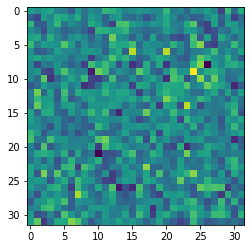

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import mul
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tfglow
tfb = tfp.bijectors
tfd = tfp.distributions

data, info = tfds.load('mnist', with_info=True)
train_data, test_data = data['train'], data['test']

preprocess = lambda x: tf.cast((tf.image.resize(x['image'], (32, 32))+tf.random.normal((32, 32, 32, 1))-0.5)/255, tf.float32)
train_data = train_data.batch(32).map(preprocess)
test_data = test_data.batch(32).map(preprocess)

x = next(iter(train_data))
print(x)
glow = tfglow.Glow(output_shape=[32, 32, 1],
                coupling_bijector_fn=ResnetGlowNetwork,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork,
                num_glow_blocks=3,
                num_steps_per_block=6)

z_shape = glow.inverse_event_shape([32, 32, 1])

pz = tfd.Sample(tfd.Normal(0., 1.), z_shape)

# Calling glow on distribution p(z) creates our glow distribution over images.
px = glow(pz)

# Take samples from the distribution to get images from your dataset
images = px.sample(2)

plt.imshow(images[0])
# Map images to positions in the distribution
z = glow.inverse(x)
print(tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2))
print(tf.reduce_mean(glow.inverse_log_det_jacobian(x)))

In [3]:
inputs = tf.keras.layers.Input(shape=(32, 32, 1), name='my_input')

In [4]:
#with tf.GradientTape() as tape:
#   outputs = glow.inverse(inputs)

In [5]:
@tf.function
def loss():
    return tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2) - tf.reduce_mean(glow.inverse_log_det_jacobian(x))


for target in train_data.take(1):
    targets = target
print(targets.shape)
with tf.GradientTape() as tape:
    log_prob_loss = loss()
grads = tape.gradient(log_prob_loss, glow.trainable_variables)
print(log_prob_loss)

2022-05-29 19:55:30.674230: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(32, 32, 32, 1)
tf.Tensor(72.21301, shape=(), dtype=float32)


In [15]:
optimizer = tf.optimizers.Adam(learning_rate=5e-4) 
log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [20]:
n_epochs = 1
n_steps=100

flag = False
for epoch in range(n_epochs):
    print("epoch", epoch)
    if flag:
        print('raise NaN')
        break
    for x in train_data:
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
        grads = tape.gradient(log_prob_loss, glow.trainable_variables)
        optimizer.apply_gradients(zip(grads, glow.trainable_variables))
        if tf.math.is_nan(log_prob_loss):
            flag=True
            break
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 10, 0):
            print("Step {} Loss {:.6f}".format(optimizer.iterations, avg_loss.result()))
            avg_loss.reset_states()
        if tf.equal(optimizer.iterations % 10, 0):
            with log.as_default():
                tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
                avg_loss.reset_states()
        if tf.equal(optimizer.iterations % n_steps, 0):
            break

epoch 0
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=210> Loss -2326.379639
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=220> Loss -2360.777832
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=230> Loss -2330.971924
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=240> Loss -2339.766357
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=250> Loss -2447.022949
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=260> Loss -2500.206055
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=270> Loss -2450.165283
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=280> Loss -2489.808594
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=290> Loss -2573.767090
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=300> Loss -2574.120117


2022-05-29 20:01:26.102099: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


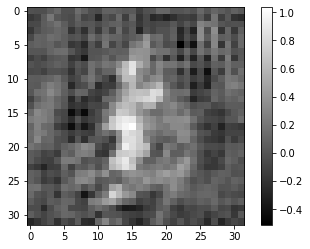

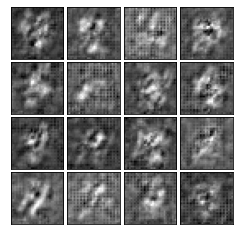

In [21]:
pz = tfd.Sample(tfd.Normal(0., 1), z_shape)
px = glow(pz)

# Take samples from the distribution to get images from your dataset
images = px.sample(2)

plt.imshow(images[0], cmap='gray')
plt.colorbar()

import utils
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
x_samples_np=px.sample(16)
utils.plot_4x4_grid(x_samples_np, shape=x_samples_np.shape[1:3])

In [22]:
#z = glow(np.zeros((1024)))
#x0 = glow(z)
#plt.imshow(x0[0], cmap='gray')
#plt.colorbar()

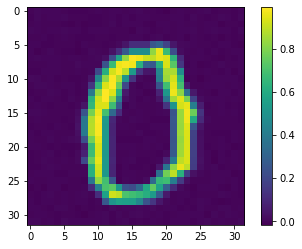

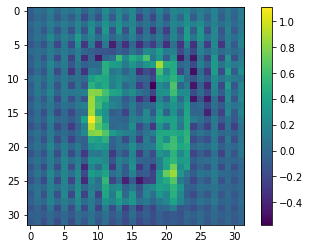

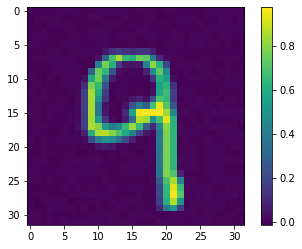

In [24]:
#Test mixing of two images from a batch
z=glow.inverse(x.numpy()).numpy()
z1=z[5]
z2=z[3]
z[0]=z1
z[2]=z2
z[1]=(z1+z2)/2
plt.figure()
plt.imshow(glow(z)[0, :, :, 0])
plt.colorbar()
plt.figure()
plt.imshow(glow(z)[1, :, :, 0])
plt.colorbar()
plt.figure()
plt.imshow(glow(z)[2, :, :, 0])
plt.colorbar()

In [12]:
tf.reduce_mean(glow.inverse_log_det_jacobian(x))

<tf.Tensor: shape=(), dtype=float32, numpy=452.11777>

In [13]:
tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2)

<tf.Tensor: shape=(), dtype=float32, numpy=54.64447>

In [14]:
tf.reduce_mean(glow.inverse_log_det_jacobian(x))

<tf.Tensor: shape=(), dtype=float32, numpy=452.11777>

In [27]:
loss()

<tf.Tensor: shape=(), dtype=float32, numpy=-2406.501>

In [28]:
tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2) - tf.reduce_mean(glow.inverse_log_det_jacobian(x))

<tf.Tensor: shape=(), dtype=float32, numpy=-2179.4512>

In [29]:
loss()

<tf.Tensor: shape=(), dtype=float32, numpy=-2406.501>

In [30]:
@tf.function
def loss1():
    return tf.reduce_mean(tf.reduce_sum(tf.math.pow(glow.inverse(x), 2), axis=(1))/2) - tf.reduce_mean(glow.inverse_log_det_jacobian(x))
loss1()

<tf.Tensor: shape=(), dtype=float32, numpy=-2179.4512>

In [31]:
glow.compile(optimizer='adam', loss=loss)

glow.fit(x_train, None, epochs=10, shuffle=True, validation_data=(x_test))


AttributeError: 'Glow' object has no attribute 'compile'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import mul
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

data, info = tfds.load('mnist', with_info=True)
train_data, test_data = data['train'], data['test']

preprocess = lambda x: tf.cast(tf.image.resize(x['image']/255, (32, 32)), tf.float32)
train_data = train_data.batch(32).map(preprocess)
test_data = test_data.batch(32).map(preprocess)

x = next(iter(train_data))
print(x)
glow = tfb.Glow(output_shape=[32, 32, 1],
                coupling_bijector_fn=tfb.GlowDefaultNetwork,
                exit_bijector_fn=tfb.GlowDefaultExitNetwork)






2022-05-12 14:19:23.659255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

In [3]:
inputs = tf.keras.layers.Input(shape=(32, 32, 1), name='my_input')
outputs = glow.inverse(inputs)
model = MyModel(inputs, outputs)

optimizer = tf.optimizers.Adam(learning_rate=2e-5) 
model.compile(optimizer, loss=loss, steps_per_execution=10)
model.fit(train_data, epochs=2, steps_per_epoch=10)


TypeError: Exception encountered when calling layer "tf.concat" (type TFOpLambda).

Tensors in list passed to 'values' of 'ConcatV2' Op have types [int32, int64] that don't all match.

Call arguments received:
  • values=['tf.Tensor(shape=(1,), dtype=int32)', 'tf.Tensor(shape=(5,), dtype=int64)']
  • axis=0
  • name='output_shape'